In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from plotly import graph_objects as go
%config InlineBackend.figure_format='retina'

# ACC Ridge

In [2]:
trajdir = '/data/oceanparcels/output_data/data_Daan/project_diffusion/dispersion/'

In [3]:
traj_fine = xr.open_dataset(trajdir + "absolute_dispersion_ACC_ridge_fine_advection_180d_dt40m.nc", decode_times=False)
traj_coarsened = xr.open_dataset(trajdir + "absolute_dispersion_ACC_ridge_coarsened_advection_180d_dt40m.nc", decode_times=False)
traj_coarse = xr.open_dataset(trajdir + "absolute_dispersion_ACC_ridge_coarse_advection_180d_dt40m.nc", decode_times=False)

In [4]:
traj_coarsened_markov1 = xr.open_dataset(trajdir + "absolute_dispersion_ACC_ridge_coarsened_180d_Markov1_K15000_dt40m.nc", decode_times=False)
traj_coarse_markov1 = xr.open_dataset(trajdir + "absolute_dispersion_ACC_ridge_coarse_180d_Markov1_K15000_dt40m.nc", decode_times=False)

In [5]:
# compute residuals
traj_fine['resid_U'] = traj_fine.inst_U - traj_fine.mean_U
traj_fine['resid_V'] = traj_fine.inst_V - traj_fine.mean_V
traj_fine['resid_W'] = traj_fine.inst_W - traj_fine.mean_W

traj_coarsened_markov1 = traj_coarsened_markov1.rename({'u_prime' : 'resid_U',
                    'v_prime' : 'resid_V',
                    'w_prime' : 'resid_W'})
traj_coarse_markov1 = traj_coarse_markov1.rename({'u_prime' : 'resid_U',
                    'v_prime' : 'resid_V',
                    'w_prime' : 'resid_W'})

# Velocity autocorrelations

$R_{ij}(\tau) = \overline{u_i'(t) u_j'(t+\tau)}/[\overline{u_i'^2} \overline{u_j'^2}]^{1/2}$. 

In [6]:
def compute_velocity_autocorr(ds, start=0, stop=-1, mode='forward'):
    dimMap = {"x" : "U", "y" : "V", "z" : "W"}
    
    T = int(ds.obs[-1]-ds.obs[start])
    
    R = dict()
    for dim1 in ["x", "y", "z"]:
        for dim2 in ["x", "y", "z"]:
            if mode == 'forward':
                R[f"{dim1}{dim2}"] = np.array([float(np.nanmean(ds[f"resid_{dimMap[dim1]}"].isel(obs=start)*ds[f"resid_{dimMap[dim2]}"].isel(obs=tau+start))/np.sqrt((np.nanmean(ds[f"resid_{dimMap[dim1]}"].isel(obs=start)**2)*np.nanmean(ds[f"resid_{dimMap[dim2]}"].isel(obs=tau+start)**2)))) for tau in range(T)])
            elif mode == 'backward':
                R[f"{dim1}{dim2}"] = np.array([float(np.nanmean(ds[f"resid_{dimMap[dim1]}"].isel(obs=stop)*ds[f"resid_{dimMap[dim2]}"].isel(obs=stop-tau))/np.sqrt((np.nanmean(ds[f"resid_{dimMap[dim1]}"].isel(obs=stop)**2)*np.nanmean(ds[f"resid_{dimMap[dim2]}"].isel(obs=stop-tau)**2)))) for tau in range(T)])


    return R

### Fine (5 km)

In [7]:
corr_fine_forward = compute_velocity_autocorr(traj_fine, mode='forward')
corr_fine_backward = compute_velocity_autocorr(traj_fine, mode='backward')

In [8]:
# idealized autocorrelation
t = np.arange(180)
Tl = 20
omega = 1/75

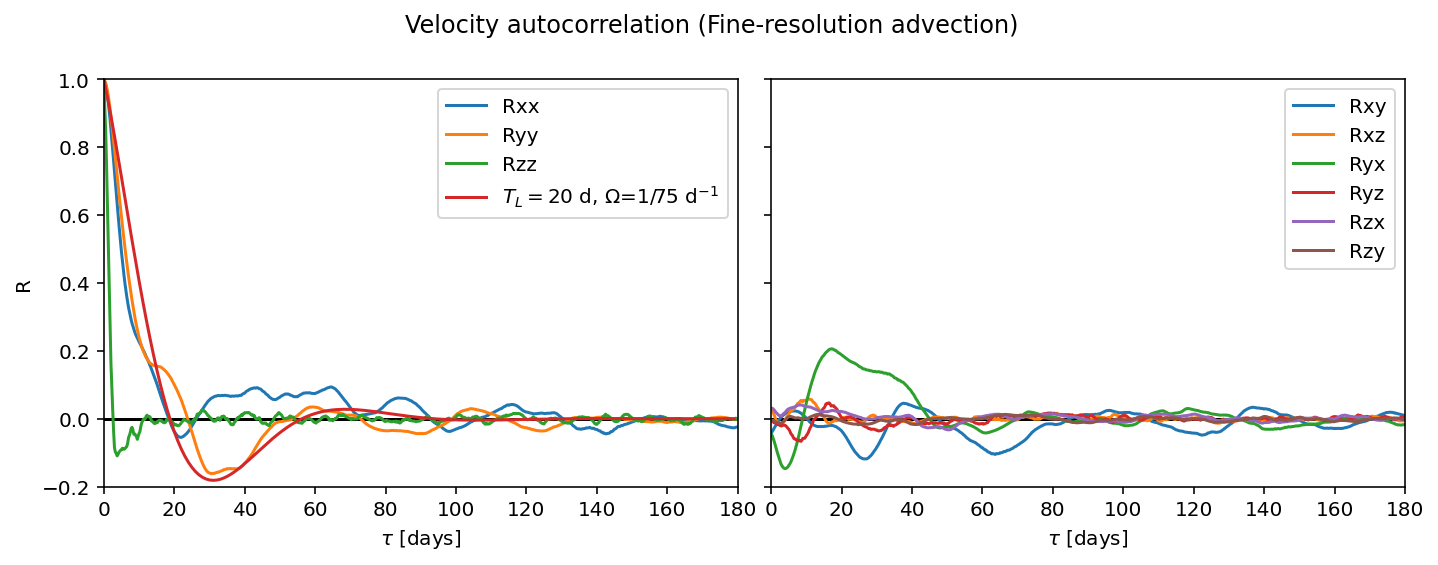

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
for key, value in corr_fine_forward.items():
    if key[0] == key[1]:
        ax[0].plot(np.arange(720)/4, value, label='R'+key)
    else:
        ax[1].plot(np.arange(720)/4, value, label='R'+key)
for axis in ax:
    axis.set_xlim(0, 180)
    axis.set_ylim(-0.2, 1)
    axis.set_xlabel(r'$\tau$ [days]')
    axis.axhline(y=0, xmin=0, xmax=1, color='black', zorder=0)
    axis.legend()
ax[0].set_ylabel('R')
ax[1].set_yticklabels([])

ax[0].plot(t, np.exp(-t/Tl)*np.cos(omega*t*2*np.pi), label=r'$T_L=20$ d, $\Omega$=1/75 d$^{-1}$')
ax[0].legend()

fig.suptitle("Velocity autocorrelation (Fine-resolution advection)")
fig.tight_layout()
plt.savefig("viz/fine_advection_autocorr.pdf", dpi=300)
plt.show()

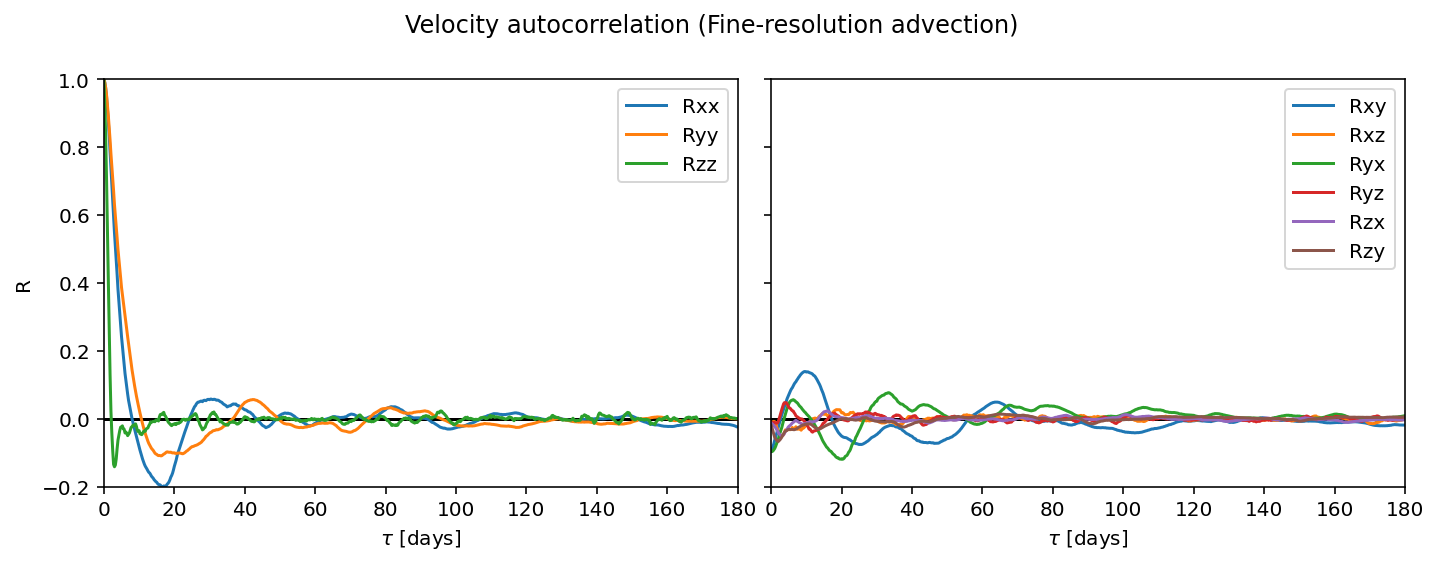

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
for key, value in corr_fine_backward.items():
    if key[0] == key[1]:
        ax[0].plot(np.arange(720)/4, value, label='R'+key)
    else:
        ax[1].plot(np.arange(720)/4, value, label='R'+key)
for axis in ax:
    axis.set_xlim(0, 180)
    axis.set_ylim(-0.2, 1)
    axis.set_xlabel(r'$\tau$ [days]')
    axis.axhline(y=0, xmin=0, xmax=1, color='black', zorder=0)
    axis.legend()
ax[0].set_ylabel('R')
ax[1].set_yticklabels([])
fig.suptitle("Velocity autocorrelation (Fine-resolution advection)")
fig.tight_layout()
plt.show()

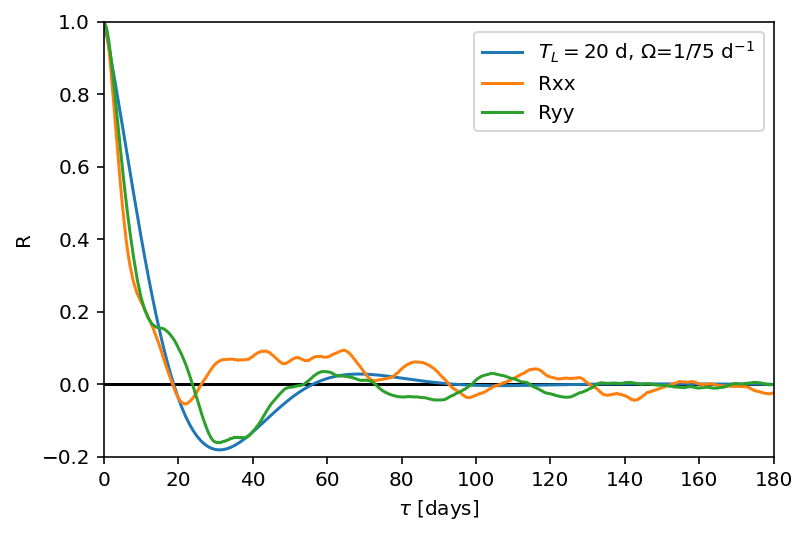

In [11]:
fig, ax = plt.subplots()
ax.plot(t, np.exp(-t/Tl)*np.cos(omega*t*2*np.pi), label=r'$T_L=20$ d, $\Omega$=1/75 d$^{-1}$')
ax.plot(np.arange(720)/4, corr_fine_forward['xx'], label='Rxx')
ax.plot(np.arange(720)/4, corr_fine_forward['yy'], label='Ryy')
ax.set_xlim(0, 180)
ax.set_ylim(-0.2, 1)
ax.set_xlabel(r'$\tau$ [days]')
ax.set_ylabel('R')
ax.axhline(y=0, xmin=0, xmax=1, color='black', zorder=0)
ax.legend()
plt.show()

### Coarsened + Markov-1 (5 --> 50 km, $T_L$ = 20 days, $K=15000$ $m^2/s$)

In [12]:
traj_coarsened_markov1_nonzero = traj_coarsened_markov1.where(traj_coarsened_markov1.resid_U != 0)

In [13]:
corr_coarsened_markov1 = compute_velocity_autocorr(traj_coarsened_markov1_nonzero)

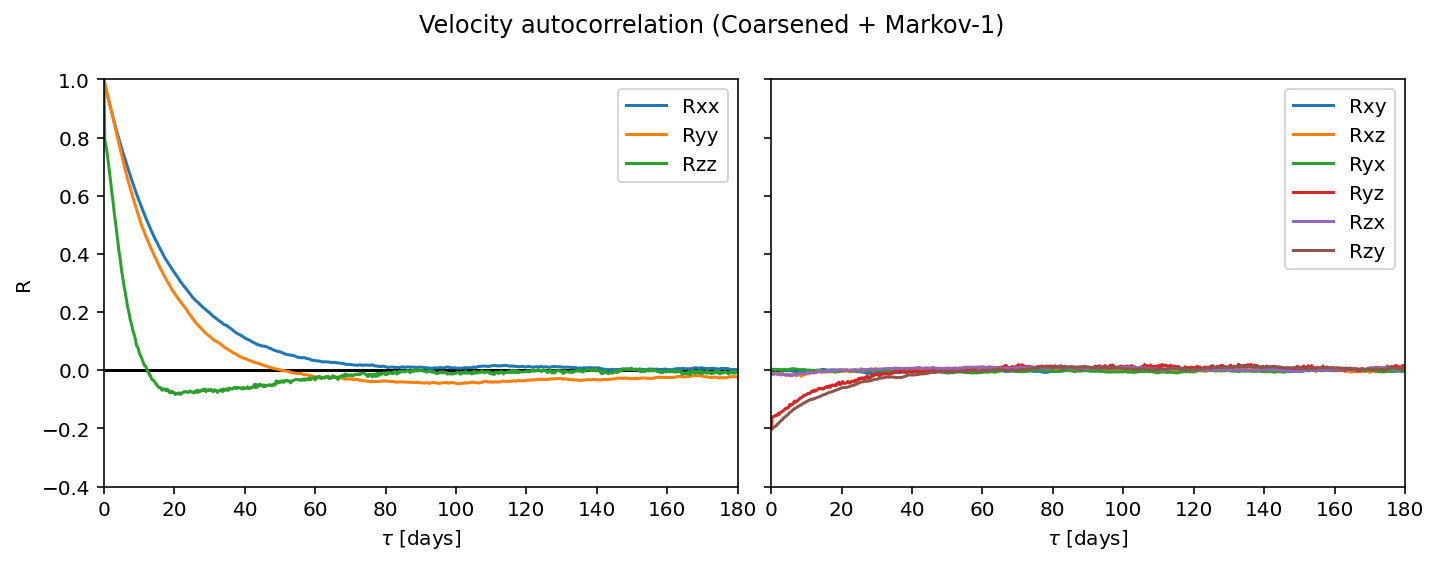

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
for key, value in corr_coarsened_markov1.items():
    if key[0] == key[1]:
        ax[0].plot(np.arange(720)/4, value, label='R'+key)
    else:
        ax[1].plot(np.arange(720)/4, value, label='R'+key)
# ax[0].plot(t, np.exp(-t/Tl), label='Tl=20')
for axis in ax:
    axis.set_xlim(0, 180)
    axis.set_ylim(-0.4, 1)
    axis.set_xlabel(r'$\tau$ [days]')
    axis.axhline(y=0, xmin=0, xmax=1, color='black', zorder=0)
    axis.legend()


ax[0].set_ylabel('R')
ax[1].set_yticklabels([])
fig.suptitle("Velocity autocorrelation (Coarsened + Markov-1)")
fig.tight_layout()
plt.savefig("viz/coarsened_markov1_autocorr.pdf", dpi=300)
plt.show()

### Coarse (50 km, $T_L$ = 20 days, $K=15000$ $m^2/s$)

In [15]:
traj_coarse_markov1_nonzero = traj_coarse_markov1.where(traj_coarse_markov1.resid_U != 0)

In [16]:
corr_coarse_markov1 = compute_velocity_autocorr(traj_coarse_markov1_nonzero)

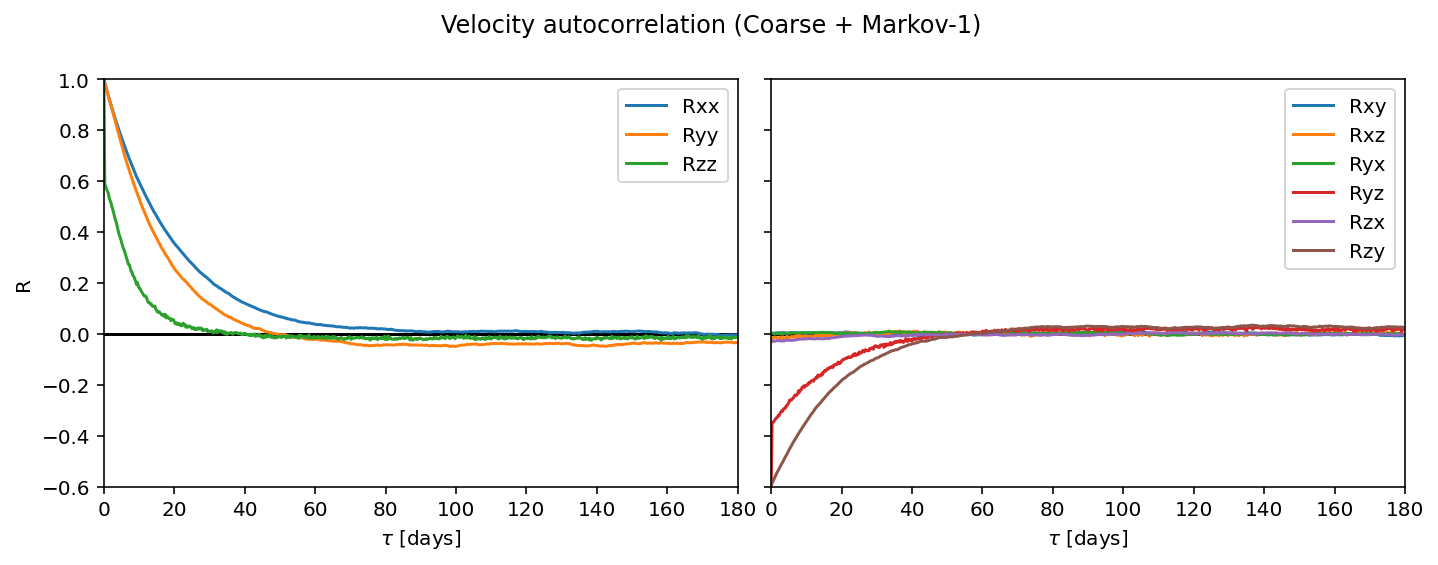

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
for key, value in corr_coarse_markov1.items():
    if key[0] == key[1]:
        ax[0].plot(np.arange(720)/4, value, label='R'+key)
    else:
        ax[1].plot(np.arange(720)/4, value, label='R'+key)
# ax[0].plot(t, np.exp(-t/Tl), label='Tl=20')
for axis in ax:
    axis.set_xlim(0, 180)
    axis.set_ylim(-0.6, 1)
    axis.set_xlabel(r'$\tau$ [days]')
    axis.axhline(y=0, xmin=0, xmax=1, color='black', zorder=0)
    axis.legend()
ax[0].set_ylabel('R')
ax[1].set_yticklabels([])
fig.suptitle("Velocity autocorrelation (Coarse + Markov-1)")
fig.tight_layout()
plt.savefig("viz/coarse_markov1_autocorr.pdf", dpi=300)
plt.show()

# Asymptotic diffusivity

$\kappa_{ij}(\mathbf{x}, \tau) = \int_{-\tau}^0 R_{ij}(\tilde{\tau})d\tilde{\tau} = \int_{-\tau}^0  d\tilde{\tau}\langle u'_i (t_0 | \mathbf{x}, t_0)u'_j(t_0+\tilde{\tau}|\mathbf{x}, t_0) \rangle_L$

In [18]:
def compute_asymptotic_diffusivity(ds, start=0, stop=-1, dt=6*60*60, mode='forward'):
    dims = ["x", "y", "z"]
    velos = ["U", "V", "W"]
    dimMap = dict(zip(dims, velos))
    
    T = int(ds.obs[stop]-ds.obs[start])
    print("Amount of steps: ",T)
    print("dt: ",dt)
    K = dict()
    for dim1 in dims:
        for dim2 in dims:
            if mode == 'forward':
                K[f"{dim1}{dim2}"] = np.cumsum(np.array([float(dt*np.nanmean(ds[f"resid_{dimMap[dim1]}"].isel(obs=start)*ds[f"resid_{dimMap[dim2]}"].isel(obs=tau))) for tau in range(T)]))
            elif mode == 'backward':
                K[f"{dim1}{dim2}"] = np.cumsum(np.array([float(dt*np.nanmean(ds[f"resid_{dimMap[dim1]}"].isel(obs=-1)*ds[f"resid_{dimMap[dim2]}"].isel(obs=-1-tau))) for tau in range(T)]))
            
    return K

### Fine (5 km)

In [19]:
diff_fine_forward = compute_asymptotic_diffusivity(traj_fine, mode='forward')
diff_fine_backward = compute_asymptotic_diffusivity(traj_fine, mode='backward')

Amount of steps:  720
dt:  21600
Amount of steps:  720
dt:  21600


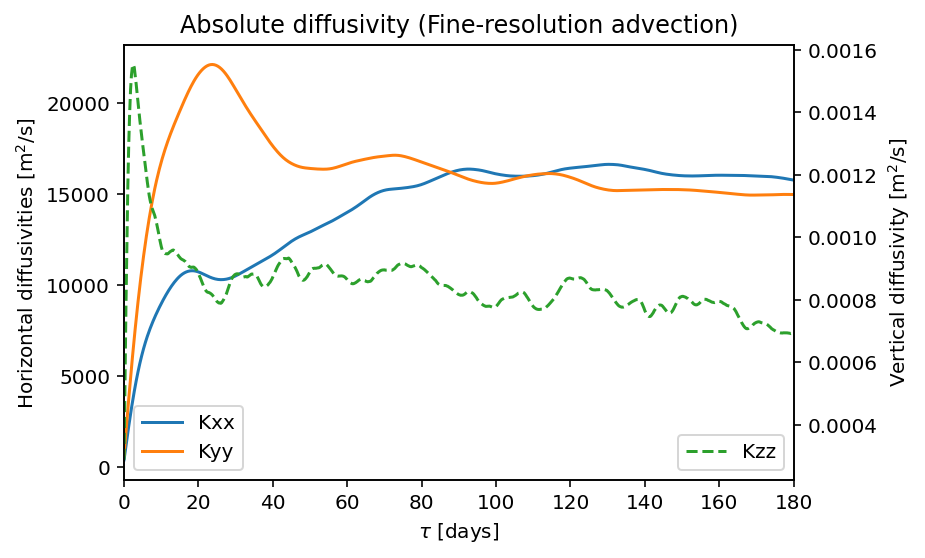

In [20]:
fig, ax = plt.subplots(ncols=1, figsize=(6,4))
axb = ax.twinx()
for key, value in diff_fine_forward.items():
    if key[0] == key[1]:
        if 'z' in key:
            axb.plot(np.arange(720)/4, value, label='K'+key, linestyle='--', color='C2')
        else:
            ax.plot(np.arange(720)/4, value, label='K'+key)
ax.set_xlim(0, 180)
ax.set_xlabel(r'$\tau$ [days]')
ax.set_ylabel(f'Horizontal diffusivities [m$^2$/s]')
axb.set_ylabel(f'Vertical diffusivity [m$^2$/s]')
ax.legend(loc=3)
axb.legend(loc=4)
ax.set_title("Absolute diffusivity (Fine-resolution advection)")
plt.savefig("viz/fine_advection_diffusivity.pdf", dpi=300, bbox_inches='tight')
plt.show()

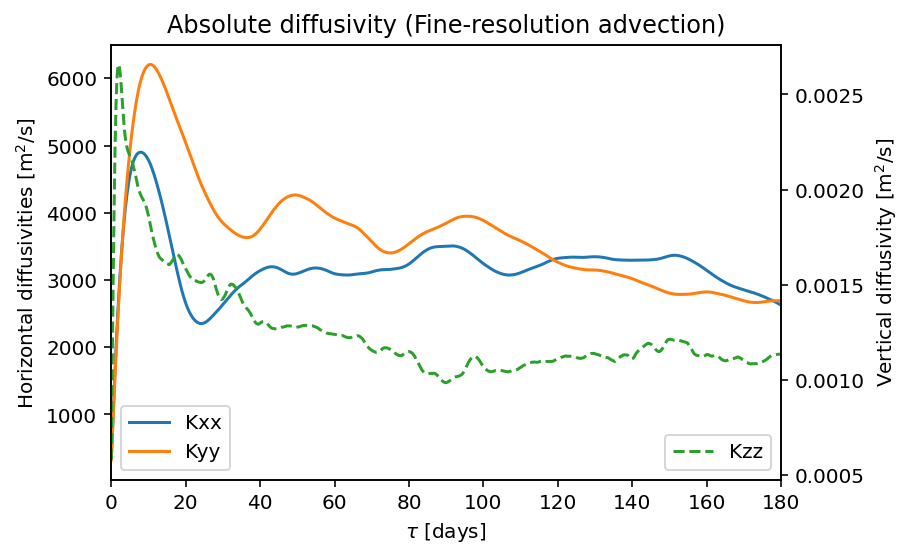

In [21]:
fig, ax = plt.subplots(ncols=1, figsize=(6,4))
axb = ax.twinx()
for key, value in diff_fine_backward.items():
    if key[0] == key[1]:
        if 'z' in key:
            axb.plot(np.arange(720)/4, value, label='K'+key, linestyle='--', color='C2')
        else:
            ax.plot(np.arange(720)/4, value, label='K'+key)
ax.set_xlim(0, 180)
ax.set_xlabel(r'$\tau$ [days]')
ax.set_ylabel(f'Horizontal diffusivities [m$^2$/s]')
axb.set_ylabel(f'Vertical diffusivity [m$^2$/s]')
ax.legend(loc=3)
axb.legend(loc=4)
ax.set_title("Absolute diffusivity (Fine-resolution advection)")
# plt.savefig("viz/fine_advection_diffusivity.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [22]:
K_fine = np.zeros((3,3))
for i, dim1 in enumerate(["x", "y", "z"]):
    for j, dim2 in enumerate(["x", "y", "z"]):
        K_fine[i,j] = diff_fine_forward[f"{dim1}{dim2}"][-1]

In [23]:
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

In [24]:
symmetrize(K_fine)

array([[ 1.57655077e+04,  1.71246339e+03,  1.28611794e+00],
       [ 1.71246339e+03,  1.49631934e+04, -1.16175573e+00],
       [ 1.28611794e+00, -1.16175573e+00,  6.92228758e-04]])

In [25]:
eigenvalues, eigenvectors = np.linalg.eig(symmetrize(K_fine))

In [26]:
eigenvalues

array([1.71231734e+04, 1.36055279e+04, 4.72688231e-04])

In [27]:
eigenvectors

array([[-7.83607920e-01, -6.21255680e-01, -9.11444115e-05],
       [-6.21255687e-01,  7.83607915e-01,  8.80719238e-05],
       [-1.67062993e-05, -1.25637841e-04,  9.99999992e-01]])

For $\tau=20$ days, the eigendecomposition yields two major components that fall mostly in the x,y plane, while the third, minor component lies chiefly in the z-plane

### Coarsened + Markov-1 (5 --> 50 km, $T_L$ = 20 days, $K=15000$ $m^2/s$)

In [28]:
diff_coarsened_markov1 = compute_asymptotic_diffusivity(traj_coarsened_markov1, dt=6*60*60)

Amount of steps:  720
dt:  21600


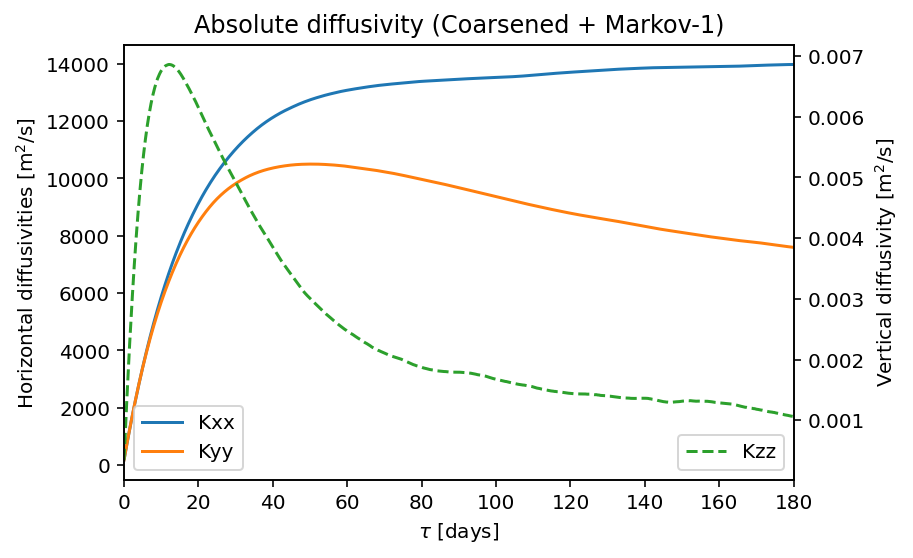

In [29]:
fig, ax = plt.subplots(ncols=1, figsize=(6,4))
axb = ax.twinx()
for key, value in diff_coarsened_markov1.items():
    if key[0] == key[1]:
        if 'z' in key:
            axb.plot(np.arange(720)/4, value, label='K'+key, linestyle='--', color='C2')
        else:
            ax.plot(np.arange(720)/4, value, label='K'+key)
ax.set_xlim(0, 180)
ax.set_xlabel(r'$\tau$ [days]')
ax.set_ylabel(f'Horizontal diffusivities [m$^2$/s]')
axb.set_ylabel(f'Vertical diffusivity [m$^2$/s]')
ax.legend(loc=3)
axb.legend(loc=4)
ax.set_title("Absolute diffusivity (Coarsened + Markov-1)")
plt.savefig("viz/coarsened_markov1_diffusivity.pdf", dpi=300, bbox_inches='tight')
plt.show()

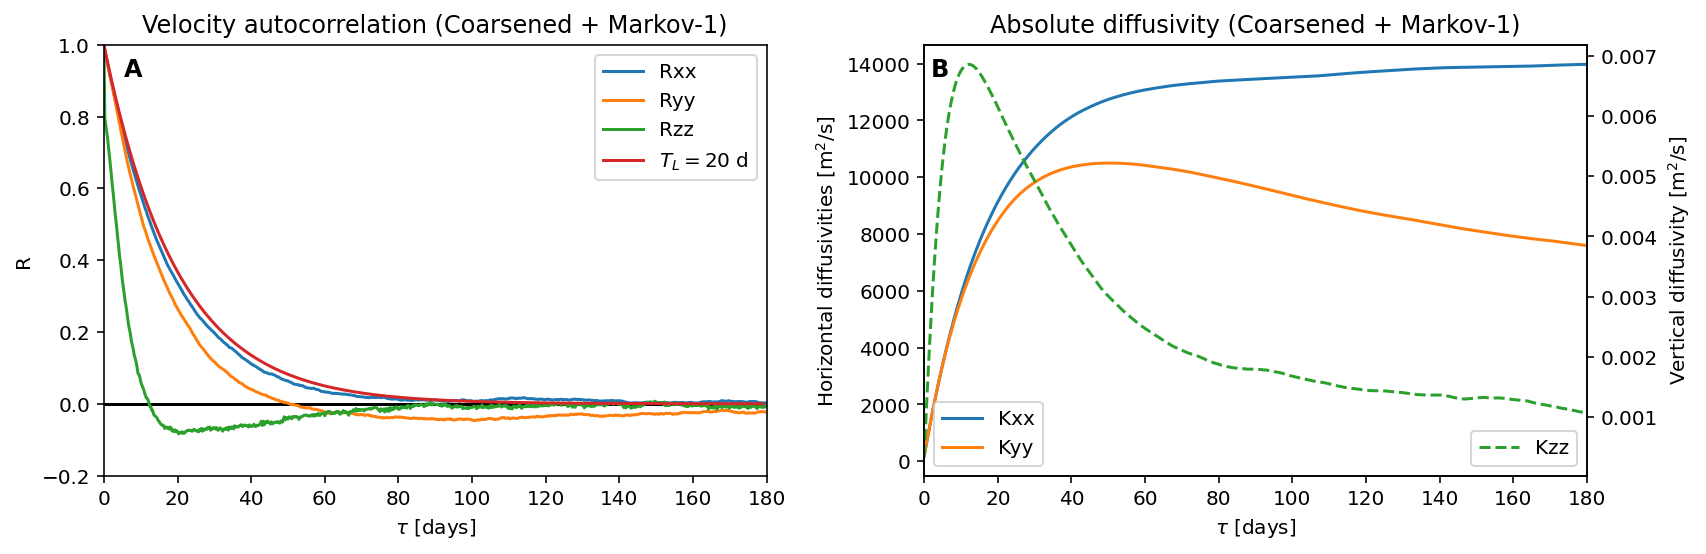

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
for key, value in corr_coarsened_markov1.items():
    if key[0] == key[1]:
        if key[0] =='zz':
            ax[0].plot(np.arange(720)/4, value, label='R'+key, linestyle='--')
        else:
            ax[0].plot(np.arange(720)/4, value, label='R'+key)
ax[0].set_ylabel('R')
ax[0].set_title("Velocity autocorrelation (Coarsened + Markov-1)")
ax[0].set_xlim(0, 180)
ax[0].set_ylim(-0.2, 1)
ax[0].set_xlabel(r'$\tau$ [days]')
ax[0].axhline(y=0, xmin=0, xmax=1, color='black', zorder=0)
ax[0].plot(t, np.exp(-t/Tl), label=r'$T_L=20$ d')
ax[0].legend()
ax[0].text(0.03, 0.97, 'A', va='top', fontsize='large', weight='heavy', transform = ax[0].transAxes)
ax[0].legend()

ax1b = ax[1].twinx()
for key, value in diff_coarsened_markov1.items():
    if key[0] == key[1]:
        if 'z' in key:
            ax1b.plot(np.arange(720)/4, value, label='K'+key, linestyle='--', color='C2')
        else:
            ax[1].plot(np.arange(720)/4, value, label='K'+key)
ax[1].set_xlim(0, 180)
ax[1].set_xlabel(r'$\tau$ [days]')
ax[1].set_ylabel(f'Horizontal diffusivities [m$^2$/s]')
ax1b.set_ylabel(f'Vertical diffusivity [m$^2$/s]')
ax[1].legend(loc=3)
ax1b.legend(loc=4)
ax[1].set_title("Absolute diffusivity (Coarsened + Markov-1)")
ax[1].text(0.01, 0.97, 'B', va='top', fontsize='large', weight='heavy', transform = ax[1].transAxes)

plt.tight_layout()
plt.savefig("viz/coarsened_markov1_autocorrelation_diffusivity.pdf", bbox_inches='tight')
plt.show()

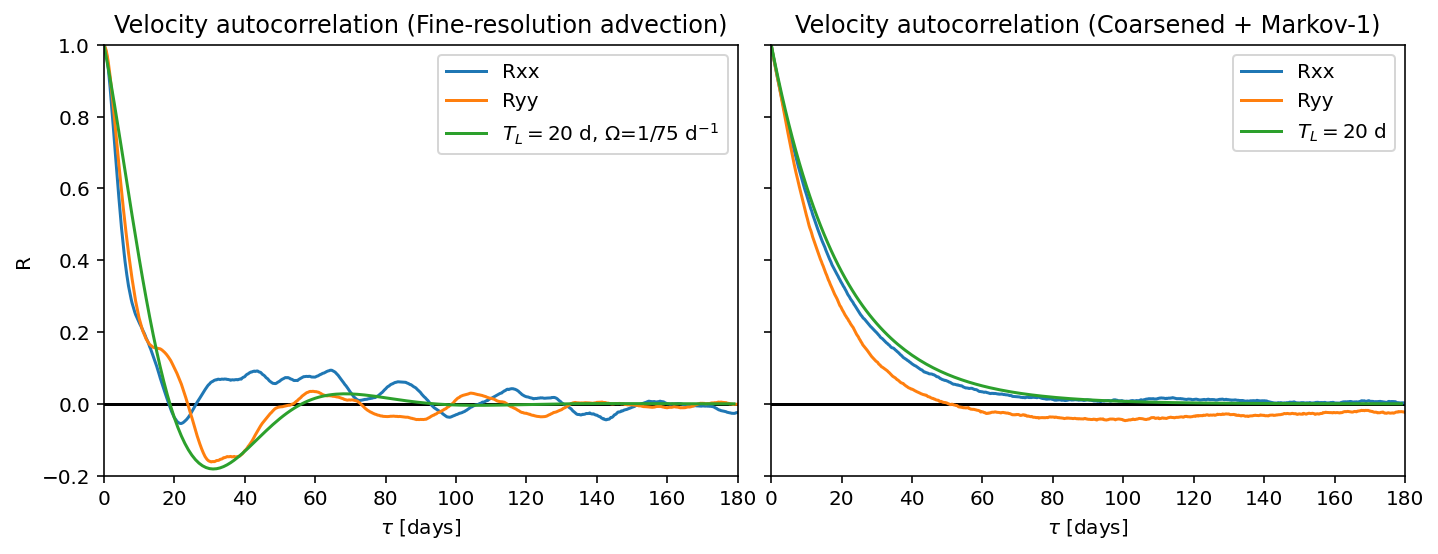

In [47]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].plot(np.arange(720)/4, corr_fine_forward['xx'], label='Rxx')
ax[0].plot(np.arange(720)/4, corr_fine_forward['yy'], label='Ryy')
ax[0].plot(t, np.exp(-t/Tl)*np.cos(omega*t*2*np.pi), label=r'$T_L=20$ d, $\Omega$=1/75 d$^{-1}$')
ax[0].set_xlim(0, 180)
ax[0].set_ylim(-0.2, 1)
ax[0].set_ylabel('R')
ax[0].set_xlabel(r'$\tau$ [days]')
ax[0].axhline(y=0, xmin=0, xmax=1, color='black', zorder=0)
ax[0].legend(loc=1)
ax[0].set_title("Velocity autocorrelation (Fine-resolution advection)")

ax[1].plot(np.arange(720)/4, corr_coarsened_markov1['xx'], label='Rxx')
ax[1].plot(np.arange(720)/4, corr_coarsened_markov1['yy'], label='Ryy')
ax[1].plot(t, np.exp(-t/Tl), label=r'$T_L=20$ d')
ax[1].set_xlim(0, 180)
ax[1].set_xlabel(r'$\tau$ [days]')
ax[1].set_ylim(-0.2, 1)
ax[1].set_yticklabels([])
ax[1].axhline(y=0, xmin=0, xmax=1, color='black', zorder=0)
ax[1].legend(loc=1)
ax[1].set_title("Velocity autocorrelation (Coarsened + Markov-1)")

plt.tight_layout()
plt.savefig("viz/coarsened_presentation_autocorrelations.pdf", bbox_inches='tight')
plt.show()

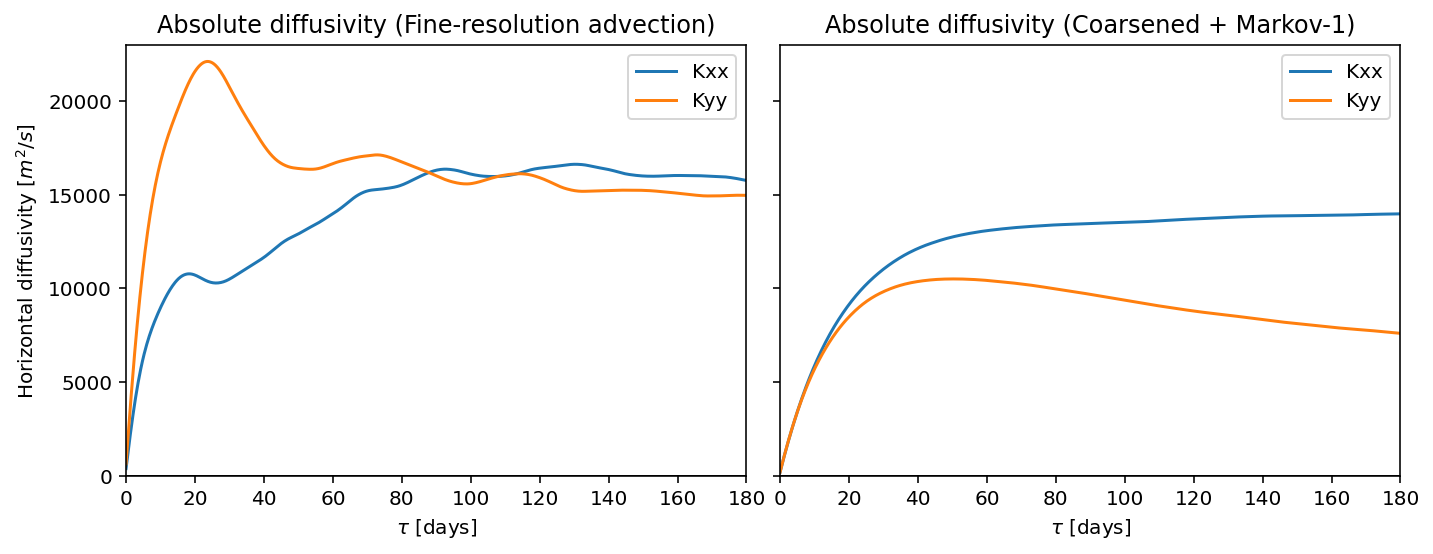

In [50]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].plot(np.arange(720)/4, diff_fine_forward['xx'], label='Kxx')
ax[0].plot(np.arange(720)/4, diff_fine_forward['yy'], label='Kyy')
ax[0].set_xlim(0, 180)
ax[0].set_ylim(0, 23000)
ax[0].set_ylabel(r'Horizontal diffusivity [$m^2/s$]')
ax[0].set_xlabel(r'$\tau$ [days]')
ax[0].axhline(y=0, xmin=0, xmax=1, color='black', zorder=0)
ax[0].legend(loc=1)
ax[0].set_title("Absolute diffusivity (Fine-resolution advection)")

ax[1].plot(np.arange(720)/4, diff_coarsened_markov1['xx'], label='Kxx')
ax[1].plot(np.arange(720)/4, diff_coarsened_markov1['yy'], label='Kyy')
ax[1].set_xlim(0, 180)
ax[1].set_xlabel(r'$\tau$ [days]')
ax[1].set_ylim(0, 23000)
ax[1].set_yticklabels([])
ax[1].axhline(y=0, xmin=0, xmax=1, color='black', zorder=0)
ax[1].legend(loc=1)
ax[1].set_title("Absolute diffusivity (Coarsened + Markov-1)")

plt.tight_layout()
plt.savefig("viz/coarsened_presentation_diffusivity.pdf", bbox_inches='tight')
plt.show()

### Coarse + Markov-1 (50 km, $T_L$ = 20 days, $K=15000$ $m^2/s$)

In [31]:
diff_coarse_markov1 = compute_asymptotic_diffusivity(traj_coarse_markov1)

Amount of steps:  720
dt:  21600


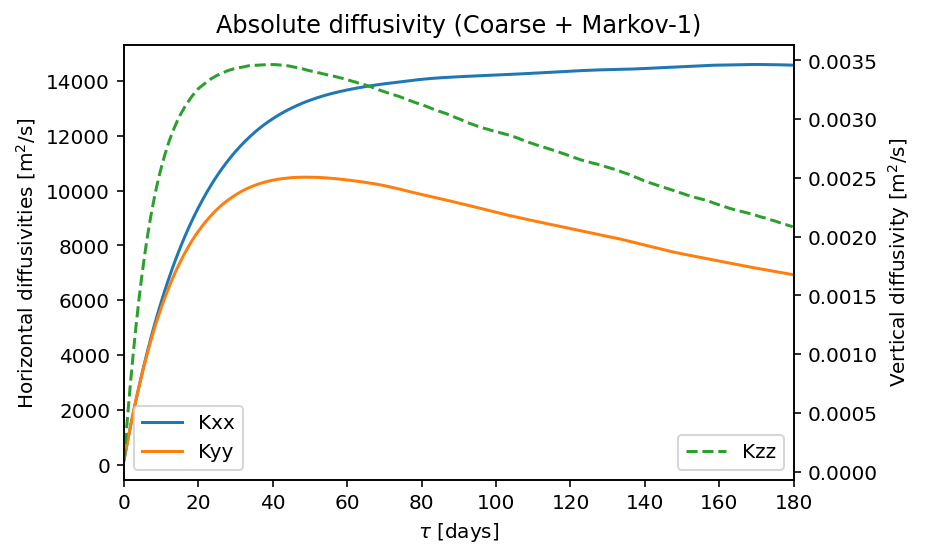

In [32]:
fig, ax = plt.subplots(ncols=1, figsize=(6,4))
axb = ax.twinx()
for key, value in diff_coarse_markov1.items():
    if key[0] == key[1]:
        if 'z' in key:
            axb.plot(np.arange(720)/4, value, label='K'+key, linestyle='--', color='C2')
        else:
            ax.plot(np.arange(720)/4, value, label='K'+key)
ax.set_xlim(0, 180)
ax.set_xlabel(r'$\tau$ [days]')
ax.set_ylabel(f'Horizontal diffusivities [m$^2$/s]')
axb.set_ylabel(f'Vertical diffusivity [m$^2$/s]')
ax.legend(loc=3)
axb.legend(loc=4)
ax.set_title("Absolute diffusivity (Coarse + Markov-1)")
plt.savefig("viz/coarse_markov1_diffusivity.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [33]:
K_coarse = np.zeros((3,3))
for i, dim1 in enumerate(["x", "y", "z"]):
    for j, dim2 in enumerate(["x", "y", "z"]):
        K_coarse[i,j] = diff_coarse_markov1[f"{dim1}{dim2}"][-1]

In [34]:
np.linalg.eig(K_coarse)

(array([1.45734309e+04, 6.93371291e+03, 4.84694582e-04]),
 array([[-9.99452900e-01, -6.04802740e-03,  2.44577429e-06],
        [-3.30741492e-02,  9.99981580e-01,  4.50830777e-04],
        [ 3.42322858e-05, -5.11345282e-04,  9.99999898e-01]]))

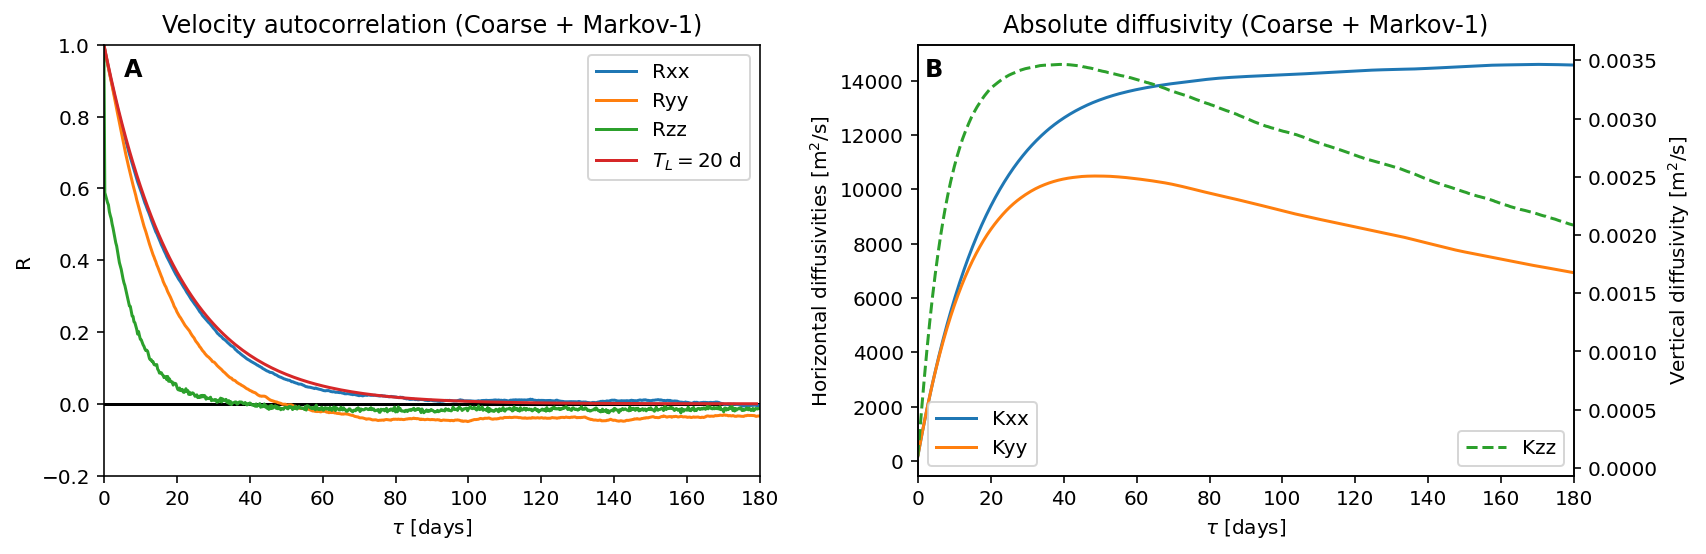

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
for key, value in corr_coarse_markov1.items():
    if key[0] == key[1]:
        if key[0] =='zz':
            ax[0].plot(np.arange(720)/4, value, label='R'+key, linestyle='--')
        else:
            ax[0].plot(np.arange(720)/4, value, label='R'+key)
ax[0].set_ylabel('R')
ax[0].set_title("Velocity autocorrelation (Coarse + Markov-1)")
ax[0].set_xlim(0, 180)
ax[0].set_ylim(-0.2, 1)
ax[0].set_xlabel(r'$\tau$ [days]')
ax[0].axhline(y=0, xmin=0, xmax=1, color='black', zorder=0)
ax[0].plot(t, np.exp(-t/Tl), label=r'$T_L=20$ d')
ax[0].legend()
ax[0].text(0.03, 0.97, 'A', va='top', fontsize='large', weight='heavy', transform = ax[0].transAxes)
ax[0].legend()

ax1b = ax[1].twinx()
for key, value in diff_coarse_markov1.items():
    if key[0] == key[1]:
        if 'z' in key:
            ax1b.plot(np.arange(720)/4, value, label='K'+key, linestyle='--', color='C2')
        else:
            ax[1].plot(np.arange(720)/4, value, label='K'+key)
ax[1].set_xlim(0, 180)
ax[1].set_xlabel(r'$\tau$ [days]')
ax[1].set_ylabel(f'Horizontal diffusivities [m$^2$/s]')
ax1b.set_ylabel(f'Vertical diffusivity [m$^2$/s]')
ax[1].legend(loc=3)
ax1b.legend(loc=4)
ax[1].set_title("Absolute diffusivity (Coarse + Markov-1)")
ax[1].text(0.01, 0.97, 'B', va='top', fontsize='large', weight='heavy', transform = ax[1].transAxes)

plt.tight_layout()
plt.savefig("viz/coarse_markov1_autocorrelation_diffusivity.pdf", bbox_inches='tight')
plt.show()